## **0. 루브릭**
***

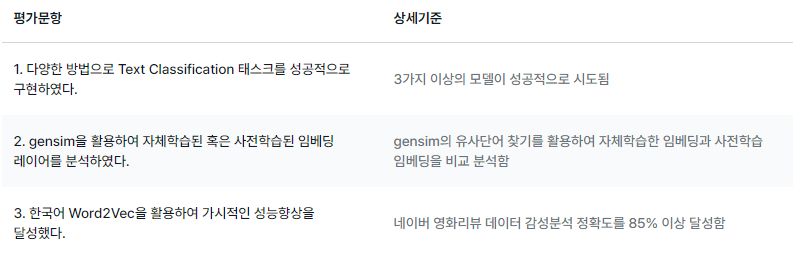

## **1. BaseLine 모델**
***

### **0) 라이브러리 불러오기**

In [16]:
# 라이브러리 불러오기
import pandas as pd
import konlpy
import gensim
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf

### **1) 데이터 준비와 확인**

In [2]:
# 데이터를 불러오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### **2) 데이터로더 구성**

`nsmc` 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있음.

이것을 읽어서 `imdb.data_loader()`와 동일하게 동작하는 자신만의 `data_loader`를 만들어 보는 것으로 시작해보자.

`data_loader`에는 다음을 수행해야 함.
* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전`word_to_index` 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

In [3]:
# data_loader 구성해보기

# 한국어 토크나이저 Mecab 객체 생성하기
tokenizer = Mecab()
# 불용어 리스트 정의하기
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# load_data 함수 정의하기
def load_data(train_data, test_data, num_words=10000):
    # 데이터의 중복 제거하기
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # NaN 결측치 제거하기
    train_data = train_data.dropna(how='any') 
    # 테스트 데이터의 중복 제거하기
    test_data.drop_duplicates(subset=['document'], inplace=True)
    # NaN 결측치 제거하기
    test_data = test_data.dropna(how='any') 
    
    # 학습 데이터 토큰화 및 불용어 제거하기
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    # 테스트 데이터 토큰화 및 불용어 제거하기
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 단어 리스트를 하나로 결합하고 빈도수 계산하기
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    # 사전 vocab 구성하기
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    # 단어 리스트를 인덱스 리스트로 변환하는 함수 정의하기
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    # 학습 데이터와 테스트 데이터를 인덱스 리스트로 변환하기
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    # 학습 데이터, 테스트 데이터, 라벨, 사전 리턴하기
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
# 데이터 불러오기 및 전처리 수행하기
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### **3) 모델 구성을 위한 데이터 분석 및 가공**
***

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* `keras.preprocessing.sequence.pad_sequences`을 활용한 패딩 추가

In [6]:
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences

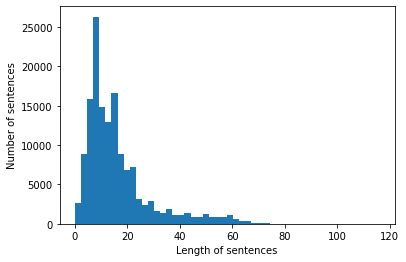

문장 길이의 평균값: 15.98
문장 길이의 최대값: 116
문장 길이의 표준편차: 12.82


In [8]:
# 문장 길이 분포 확인하기
def analyze_sentence_length(sentences):
    lengths = [len(sentence) for sentence in sentences]
    plt.hist(lengths, bins=50)
    plt.xlabel('Length of sentences')
    plt.ylabel('Number of sentences')
    plt.show()
    print(f'문장 길이의 평균값: {np.mean(lengths):.2f}')
    print(f'문장 길이의 최대값: {np.max(lengths)}')
    print(f'문장 길이의 표준편차: {np.std(lengths):.2f}')
    
analyze_sentence_length(X_train)

In [9]:
# 적절한 최대 문장 길이 지정 (예시로 평균 + 2*표준편차로 설정)
max_len = int(np.mean([len(sentence) for sentence in X_train]) + 2 * np.std([len(sentence) for sentence in X_train]))
print(f'적절한 최대 문장 길이: {max_len}')

적절한 최대 문장 길이: 41


In [10]:
# keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='post')

In [11]:
# 결과 확인하기
print(X_train_padded.shape)
print(X_test_padded.shape)

(146182, 41)
(49157, 41)


### **4) 모델 구성 및 validation set 구성**
***

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

→ 뒤에 가서 실험할 예정입니다.

validation set의 수는 test set의 수와 맞게 설정하였습니다.

즉, train 50%, validation, test은 25% 씩 설정하였습니다.

In [56]:
# validation set 만들기

# test set과 데이터 개수 맞추기
validation_size = 49517
x_val = X_train_padded[:validation_size]
y_val = y_train[:validation_size]

partial_x_train = X_train_padded[validation_size:]
partial_y_train = y_train[validation_size:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(96665, 41)
(96665,)


In [67]:
# 모델 설계하기(BaseLine 모델 : LSTM 모델)
vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원 수

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
# 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# 모델 요약 정보 출력
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_10 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### **5) 모델 훈련 개시**
***

In [68]:
# 모델 학습하기
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
189/189 [==============================] - 3s 8ms/step - loss: 0.5728 - accuracy: 0.6837 - val_loss: 0.3954 - val_accuracy: 0.8347
Epoch 2/20
189/189 [==============================] - 1s 6ms/step - loss: 0.3562 - accuracy: 0.8511 - val_loss: 0.3514 - val_accuracy: 0.8481
Epoch 3/20
189/189 [==============================] - 1s 6ms/step - loss: 0.3193 - accuracy: 0.8669 - val_loss: 0.3538 - val_accuracy: 0.8461
Epoch 4/20
189/189 [==============================] - 1s 6ms/step - loss: 0.3040 - accuracy: 0.8715 - val_loss: 0.3509 - val_accuracy: 0.8466
Epoch 5/20
189/189 [==============================] - 1s 6ms/step - loss: 0.2912 - accuracy: 0.8772 - val_loss: 0.3580 - val_accuracy: 0.8453
Epoch 6/20
189/189 [==============================] - 1s 6ms/step - loss: 0.2817 - accuracy: 0.8805 - val_loss: 0.3664 - val_accuracy: 0.8439
Epoch 7/20
189/189 [==============================] - 1s 6ms/step - loss: 0.2718 - accuracy: 0.8829 - val_loss: 0.3858 - val_accuracy: 0.8442
Epoch 

In [69]:
# 학습이 끝난 모델을 테스트셋으로 평가해보기
results = model.evaluate(X_test_padded, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.5059 - accuracy: 0.8263
[0.5059325098991394, 0.8262506127357483]


### **6) Loss, Accuracy 그래프 시각화**
***

In [70]:
history_dict = history.history

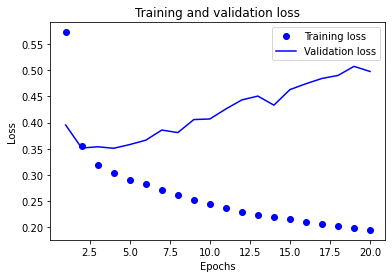

In [71]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

1. 훈련 손실(Training Loss) : 초기에는 높지만 점차적으로 감소하고 있음. 이는 모델이 훈련 데이터에 대해 점점 더 잘 맞추고 있다는 것을 의미함.
2. 검증 손실 (Validation Loss) : 초기에 감소하지만 일정한 지점 이후로는 다시 증가하는 경향을 보임. 이는 모델이 훈련 데이터에 오버피팅(overfitting)되고 있음을 알 수 있음.

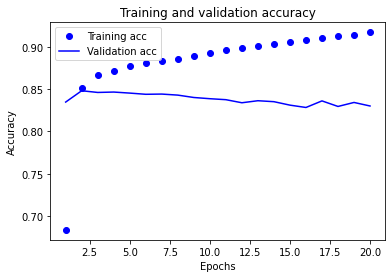

In [72]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1. 훈련 정확도 (Training Accuracy) : 훈련 정확도는 초기에는 낮지만 점차적으로 꾸준히 상승하여 결국 매우 높은 값에 도달함. 이는 모델이 훈련 데이터에 대해 점점 더 잘 맞추고 있다는 것을 의미함.
2. 검증 정확도 (Validation Accuracy) : 증 정확도는 초기에는 약간 증가하다가 일정한 수준에서 머물고 있음. 이는 모델이 훈련 데이터에서는 잘 작동하지만 검증 데이터에서는 성능 향상이 거의 없음을 나타냄.

### **7) 학습된 Embedding 레이어 분석**
***

In [73]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [74]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [78]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 0.12742926, -0.18627293,  0.13385549,  0.04139299,  0.14818643,
       -0.18311709, -0.11513021,  0.13339716, -0.13349417, -0.01545434,
       -0.14975978,  0.01714092, -0.04263404,  0.07423936,  0.1660633 ,
       -0.0286078 ], dtype=float32)

In [79]:
word_vectors.similar_by_word("사랑")

[('명작', 0.9499235153198242),
 ('따뜻', 0.9440934062004089),
 ('아닐까', 0.9371929168701172),
 ('여운', 0.9358231425285339),
 ('재미있', 0.9277815818786621),
 ('눈물', 0.9207239747047424),
 ('10', 0.9205044507980347),
 ('깊', 0.9197137355804443),
 ('만족', 0.9185307621955872),
 ('반영', 0.917852520942688)]

In [ ]:
사전 학습

### **8) 한국어 Word2Vec 임베딩 활용하여 성능 개선**
***

* 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
* 한국어 Word2Vec을 활용할 때는 `load_word2vec_format()` 형태가 아닌 `load()` 형태로 모델을 불러와주세요.
* 모델을 활용할 때에는 아래 예시와 같이 `.wv`를 붙여서 활용합니다.

`# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv[‘끝’]`

In [90]:
from gensim.models import KeyedVectors

# 한국어 Word2Vec 모델 불러오기
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = KeyedVectors.load(word2vec_file_path)

In [91]:
vector = word_vectors.wv['끝']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [93]:
# 임베딩 매트릭스 초기화
vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 100  # Word2Vec 모델의 차원 수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [95]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    embeddings_initializer=Constant(embedding_matrix), 
                                    input_length=max_len, 
                                    trainable=True))  # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [96]:
# 모델 요약 정보 출력하기
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

In [97]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
189/189 [==============================] - 4s 8ms/step - loss: 0.6185 - accuracy: 0.6381 - val_loss: 0.5237 - val_accuracy: 0.7455
Epoch 2/20
189/189 [==============================] - 1s 6ms/step - loss: 0.4811 - accuracy: 0.7724 - val_loss: 0.4557 - val_accuracy: 0.7894
Epoch 3/20
189/189 [==============================] - 1s 6ms/step - loss: 0.4162 - accuracy: 0.8114 - val_loss: 0.4160 - val_accuracy: 0.8107
Epoch 4/20
189/189 [==============================] - 1s 6ms/step - loss: 0.3730 - accuracy: 0.8347 - val_loss: 0.3975 - val_accuracy: 0.8248
Epoch 5/20
189/189 [==============================] - 1s 6ms/step - loss: 0.3441 - accuracy: 0.8504 - val_loss: 0.3793 - val_accuracy: 0.8313
Epoch 6/20
189/189 [==============================] - 1s 6ms/step - loss: 0.3197 - accuracy: 0.8632 - val_loss: 0.3745 - val_accuracy: 0.8347
Epoch 7/20
189/189 [==============================] - 1s 6ms/step - loss: 0.2993 - accuracy: 0.8744 - val_loss: 0.3719 - val_accuracy: 0.8397
Epoch 

In [99]:
# 테스트셋을 통한 모델 평가하기
results = model.evaluate(X_test_padded, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.5382 - accuracy: 0.8252
[0.5381911993026733, 0.8251724243164062]


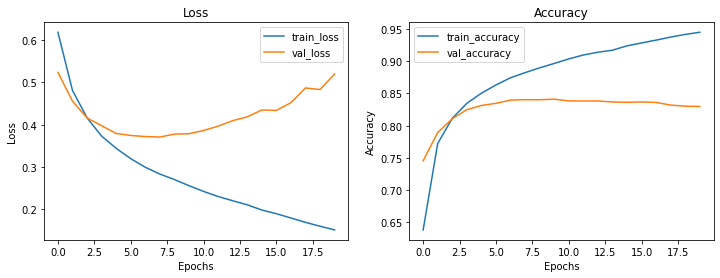

In [100]:
# 학습 결과 출력하기
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

plot_history(history)

## **2. 실험해보기**
***

### **옵티마이저(optimizer), 손실 함수(loss), 메트릭(metrics) 선정이유**

1. 옵티마이저(Optimizer): Adam
* 적응적 학습률: Adam은 각 매개변수에 대해 학습률을 개별적으로 조정할 수 있음. 이로 인해 훈련이 더 빠르고 효율적으로 진행될 수 있음.
* 모멘텀 및 RMSProp의 결합: Adam은 모멘텀과 RMSProp의 장점을 결합하여, 기울기의 일관된 방향을 따르면서도, 과도한 진동을 억제할 수 있음.

2. 손실 함수(Loss): Binary Crossentropy
* 이진 분류: 문제의 본질이 이진 분류 문제일 때, binary crossentropy는 가장 적합한 손실 함수
* 확률 기반: 이 함수는 모델의 출력이 특정 클래스일 확률을 최대화하는 방향으로 학습을 진행함.

3. 메트릭(Metrics): Accuracy
* 직관적 이해: 전체 샘플 중 올바르게 분류된 샘플의 비율을 나타내므로, 모델 성능을 직관적으로 이해하는 데 도움이 됨.
* 평가의 용이성: 모델의 성능을 평가하고 비교하기 용이한 지표

In [101]:
# 데이터를 불러오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [102]:
# data_loader 구성해보기

# 한국어 토크나이저 Mecab 객체 생성하기
tokenizer = Mecab()
# 불용어 리스트 정의하기
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# load_data 함수 정의하기
def load_data(train_data, test_data, num_words=10000):
    # 데이터의 중복 제거하기
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # NaN 결측치 제거하기
    train_data = train_data.dropna(how='any') 
    # 테스트 데이터의 중복 제거하기
    test_data.drop_duplicates(subset=['document'], inplace=True)
    # NaN 결측치 제거하기
    test_data = test_data.dropna(how='any') 
    
    # 학습 데이터 토큰화 및 불용어 제거하기
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    # 테스트 데이터 토큰화 및 불용어 제거하기
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 단어 리스트를 하나로 결합하고 빈도수 계산하기
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    # 사전 vocab 구성하기
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    # 단어 리스트를 인덱스 리스트로 변환하는 함수 정의하기
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    # 학습 데이터와 테스트 데이터를 인덱스 리스트로 변환하기
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    # 학습 데이터, 테스트 데이터, 라벨, 사전 리턴하기
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
# 데이터 불러오기 및 전처리 수행하기
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [103]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [104]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [105]:
# 문장 길이 분포 확인하기
def analyze_sentence_length(sentences):
    lengths = [len(sentence) for sentence in sentences]
    plt.hist(lengths, bins=50)
    plt.xlabel('Length of sentences')
    plt.ylabel('Number of sentences')
    plt.show()
    print(f'문장 길이의 평균값: {np.mean(lengths):.2f}')
    print(f'문장 길이의 최대값: {np.max(lengths)}')
    print(f'문장 길이의 표준편차: {np.std(lengths):.2f}')

In [106]:
# 적절한 최대 문장 길이 지정 (예시로 평균 + 2*표준편차로 설정)
max_len = int(np.mean([len(sentence) for sentence in X_train]) + 2 * np.std([len(sentence) for sentence in X_train]))

In [107]:
# keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='pre')
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='pre')

In [108]:
# validation set 만들기

# test set과 데이터 개수 맞추기
validation_size = 49517
x_val = X_train_padded[:validation_size]
y_val = y_train[:validation_size]

partial_x_train = X_train_padded[validation_size:]
partial_y_train = y_train[validation_size:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(96665, 41)
(96665,)


In [109]:
# 모델 설계하기(BaseLine 모델 : LSTM 모델)
vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원 수

In [120]:
epochs = 10

### **Conv1D 모델**

In [121]:
model_conv1d = tf.keras.Sequential()
model_conv1d.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_conv1d.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model_conv1d.add(tf.keras.layers.GlobalMaxPooling1D())
model_conv1d.add(tf.keras.layers.Dense(8, activation='relu'))
model_conv1d.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_conv1d.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

history_conv1d = model_conv1d.fit(partial_x_train,
                                  partial_y_train,
                                  epochs=epochs,
                                  batch_size=512,
                                  validation_data=(x_val, y_val),
                                  verbose=1)

results_conv1d = model_conv1d.evaluate(X_test_padded, y_test, verbose=2)
print(results_conv1d)

Epoch 1/10
189/189 [==============================] - 1s 5ms/step - loss: 0.5572 - accuracy: 0.7434 - val_loss: 0.3862 - val_accuracy: 0.8317
Epoch 2/10
189/189 [==============================] - 1s 5ms/step - loss: 0.3532 - accuracy: 0.8492 - val_loss: 0.3511 - val_accuracy: 0.8469
Epoch 3/10
189/189 [==============================] - 1s 5ms/step - loss: 0.3088 - accuracy: 0.8720 - val_loss: 0.3472 - val_accuracy: 0.8496
Epoch 4/10
189/189 [==============================] - 1s 5ms/step - loss: 0.2815 - accuracy: 0.8858 - val_loss: 0.3498 - val_accuracy: 0.8505
Epoch 5/10
189/189 [==============================] - 1s 5ms/step - loss: 0.2582 - accuracy: 0.8969 - val_loss: 0.3563 - val_accuracy: 0.8500
Epoch 6/10
189/189 [==============================] - 1s 5ms/step - loss: 0.2367 - accuracy: 0.9077 - val_loss: 0.3660 - val_accuracy: 0.8478
Epoch 7/10
189/189 [==============================] - 1s 5ms/step - loss: 0.2152 - accuracy: 0.9180 - val_loss: 0.3814 - val_accuracy: 0.8465
Epoch 

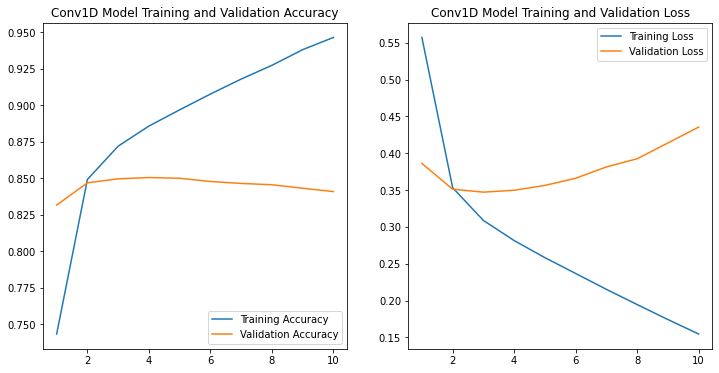

In [149]:
import matplotlib.pyplot as plt

# history 객체에서 정확도와 손실 값 가져오기
acc = history_conv1d.history['accuracy']
val_acc = history_conv1d.history['val_accuracy']
loss = history_conv1d.history['loss']
val_loss = history_conv1d.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# 정확도 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Conv1D Model Training and Validation Accuracy')

# 손실 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Conv1D Model Training and Validation Loss')

plt.show()

1. 훈련 정확도 (Training Accuracy) : 에포크(epoch)가 진행됨에 따라 지속적으로 상승하고 있음. 이는 모델이 훈련 데이터에 대해 점점 더 잘 맞추고 있다는 것을 나타냄.
2. 검증 정확도 (Validation Accuracy) : 모델이 검증 데이터에 대해 초기에는 성능이 개선되었지만 이후에는 성능이 더 이상 개선되지 않고 있음을 나타냄.
3. 훈련 손실 (Training Loss) : 모델이 훈련 데이터에 대해 점점 더 잘 맞추고 있다는 것을 나타냄.
4. 검증 손실 (Validation Loss) : 모델이 훈련 데이터에 과적합(overfitting)되고 있음을 시사함. 즉, 모델이 훈련 데이터에 너무 잘 맞추어져서 새로운 데이터(검증 데이터)에는 성능이 떨어지는 현상이 발생함.

### **LSTM + Conv1D 모델**

In [122]:
model_lstm_conv1d = tf.keras.Sequential()
model_lstm_conv1d.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm_conv1d.add(tf.keras.layers.LSTM(16, return_sequences=True))
model_lstm_conv1d.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model_lstm_conv1d.add(tf.keras.layers.GlobalMaxPooling1D())
model_lstm_conv1d.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm_conv1d.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_lstm_conv1d.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

history_lstm_conv1d = model_lstm_conv1d.fit(partial_x_train,
                                            partial_y_train,
                                            epochs=epochs,
                                            batch_size=512,
                                            validation_data=(x_val, y_val),
                                            verbose=1)

results_lstm_conv1d = model_lstm_conv1d.evaluate(X_test_padded, y_test, verbose=2)
print(results_lstm_conv1d)

Epoch 1/10
189/189 [==============================] - 4s 9ms/step - loss: 0.5137 - accuracy: 0.7507 - val_loss: 0.3731 - val_accuracy: 0.8373
Epoch 2/10
189/189 [==============================] - 1s 7ms/step - loss: 0.3420 - accuracy: 0.8533 - val_loss: 0.3504 - val_accuracy: 0.8458
Epoch 3/10
189/189 [==============================] - 1s 7ms/step - loss: 0.3154 - accuracy: 0.8674 - val_loss: 0.3456 - val_accuracy: 0.8499
Epoch 4/10
189/189 [==============================] - 1s 7ms/step - loss: 0.2980 - accuracy: 0.8755 - val_loss: 0.3474 - val_accuracy: 0.8489
Epoch 5/10
189/189 [==============================] - 1s 7ms/step - loss: 0.2825 - accuracy: 0.8831 - val_loss: 0.3512 - val_accuracy: 0.8488
Epoch 6/10
189/189 [==============================] - 1s 7ms/step - loss: 0.2684 - accuracy: 0.8893 - val_loss: 0.3515 - val_accuracy: 0.8485
Epoch 7/10
189/189 [==============================] - 1s 7ms/step - loss: 0.2514 - accuracy: 0.8970 - val_loss: 0.3643 - val_accuracy: 0.8476
Epoch 

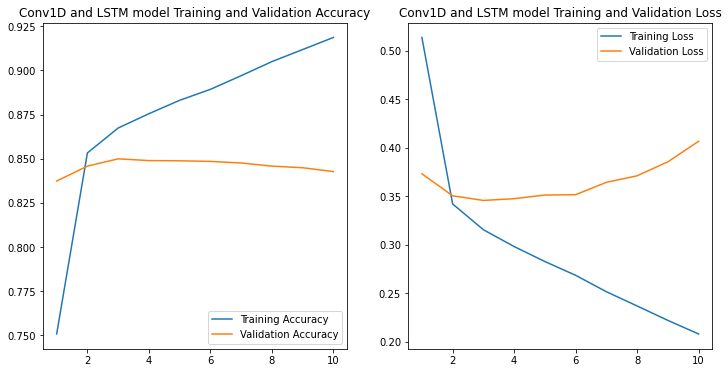

In [150]:
# history 객체에서 정확도와 손실 값 가져오기
acc = history_lstm_conv1d.history['accuracy']
val_acc = history_lstm_conv1d.history['val_accuracy']
loss = history_lstm_conv1d.history['loss']
val_loss = history_lstm_conv1d.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# 정확도 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Conv1D and LSTM model Training and Validation Accuracy')

# 손실 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Conv1D and LSTM model Training and Validation Loss')

plt.show()

1. 훈련 정확도 (Training Accuracy) : 에포크(epoch)가 진행됨에 따라 지속적으로 상승하여 결국 높은 값에 도달함. 모델이 훈련 데이터에 대해 점점 더 잘 맞추고 있다는 것을 나타냄.
2. 검증 정확도 (Validation Accuracy) : 초기 몇 에포크 동안 증가한 후 거의 일정한 수준을 유지하고 있음. 이는 모델이 검증 데이터에 대해 초기에는 성능이 개선되었지만 이후에는 성능이 더 이상 개선되지 않고 있음을 나타냄.
3. 훈련 손실 (Training Loss) : 에포크가 진행됨에 따라 지속적으로 감소하고 있음. 모델이 훈련 데이터에 대해 점점 더 잘 맞추고 있다는 것을 나타냄.
4. 검증 손실 (Validation Loss) : 초기 몇 에포크 동안 감소한 후 다시 증가하고 있음. 모델이 훈련 데이터에 과적합(overfitting)되고 있음.

### **Bidirectional LSTM 모델**

In [123]:
model_bidirectional = tf.keras.Sequential()
model_bidirectional.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_bidirectional.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)))
model_bidirectional.add(tf.keras.layers.Dense(8, activation='relu'))
model_bidirectional.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_bidirectional.compile(optimizer='adam',
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

history_bidirectional = model_bidirectional.fit(partial_x_train,
                                                partial_y_train,
                                                epochs=epochs,
                                                batch_size=512,
                                                validation_data=(x_val, y_val),
                                                verbose=1)

results_bidirectional = model_bidirectional.evaluate(X_test_padded, y_test, verbose=2)
print(results_bidirectional)

Epoch 1/10
189/189 [==============================] - 5s 12ms/step - loss: 0.5095 - accuracy: 0.7607 - val_loss: 0.3634 - val_accuracy: 0.8424
Epoch 2/10
189/189 [==============================] - 2s 9ms/step - loss: 0.3413 - accuracy: 0.8545 - val_loss: 0.3501 - val_accuracy: 0.8453
Epoch 3/10
189/189 [==============================] - 2s 8ms/step - loss: 0.3165 - accuracy: 0.8664 - val_loss: 0.3460 - val_accuracy: 0.8493
Epoch 4/10
189/189 [==============================] - 2s 9ms/step - loss: 0.3007 - accuracy: 0.8750 - val_loss: 0.3498 - val_accuracy: 0.8465
Epoch 5/10
189/189 [==============================] - 2s 9ms/step - loss: 0.2885 - accuracy: 0.8799 - val_loss: 0.3513 - val_accuracy: 0.8478
Epoch 6/10
189/189 [==============================] - 2s 9ms/step - loss: 0.2738 - accuracy: 0.8882 - val_loss: 0.3575 - val_accuracy: 0.8478
Epoch 7/10
189/189 [==============================] - 2s 9ms/step - loss: 0.2624 - accuracy: 0.8928 - val_loss: 0.3712 - val_accuracy: 0.8466
Epoch

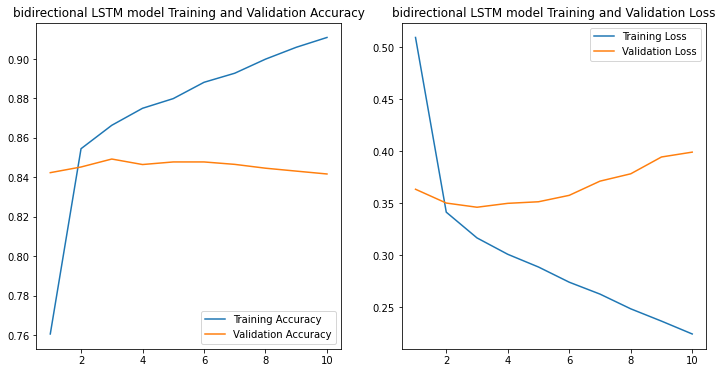

In [151]:
# history 객체에서 정확도와 손실 값 가져오기
acc = history_bidirectional.history['accuracy']
val_acc = history_bidirectional.history['val_accuracy']
loss = history_bidirectional.history['loss']
val_loss = history_bidirectional.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# 정확도 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('bidirectional LSTM model Training and Validation Accuracy')

# 손실 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('bidirectional LSTM model Training and Validation Loss')

plt.show()

1. 훈련 정확도 (Training Accuracy) : 에포크(epoch)가 진행됨에 따라 지속적으로 상승하여 높은 값에 도달함. 이는 모델이 훈련 데이터에 대해 점점 더 잘 맞추고 있다는 것을 나타냄.
2. 검증 정확도 (Validation Accuracy) : 초기 몇 에포크 동안 증가한 후 거의 일정한 수준을 유지하고 있음. 모델이 검증 데이터에 대해 초기에는 성능이 개선되었지만 이후에는 성능이 더 이상 개선되지 않고 있음.
3. 훈련 손실 (Training Loss) : 에포크가 진행됨에 따라 지속적으로 감소하고 있음. 모델이 훈련 데이터에 대해 점점 더 잘 맞추고 있다는 것을 나타냄.
4. 검증 손실 (Validation Loss) : 초기 몇 에포크 동안 감소한 후 다시 증가하고 있음. 모델이 훈련 데이터에 과적합(overfitting)되고 있음.

### **GRU 모델**

In [124]:
model_gru = tf.keras.Sequential()
model_gru.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gru.add(tf.keras.layers.GRU(16))
model_gru.add(tf.keras.layers.Dense(8, activation='relu'))
model_gru.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_gru.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_gru = model_gru.fit(partial_x_train,
                            partial_y_train,
                            epochs=epochs,
                            batch_size=512,
                            validation_data=(x_val, y_val),
                            verbose=1)

results_gru = model_gru.evaluate(X_test_padded, y_test, verbose=2)
print(results_gru)

Epoch 1/10
189/189 [==============================] - 3s 8ms/step - loss: 0.5076 - accuracy: 0.7565 - val_loss: 0.3682 - val_accuracy: 0.8379
Epoch 2/10
189/189 [==============================] - 1s 6ms/step - loss: 0.3415 - accuracy: 0.8555 - val_loss: 0.3521 - val_accuracy: 0.8474
Epoch 3/10
189/189 [==============================] - 1s 6ms/step - loss: 0.3190 - accuracy: 0.8672 - val_loss: 0.3512 - val_accuracy: 0.8499
Epoch 4/10
189/189 [==============================] - 1s 6ms/step - loss: 0.3081 - accuracy: 0.8728 - val_loss: 0.3547 - val_accuracy: 0.8481
Epoch 5/10
189/189 [==============================] - 1s 6ms/step - loss: 0.2995 - accuracy: 0.8769 - val_loss: 0.3562 - val_accuracy: 0.8480
Epoch 6/10
189/189 [==============================] - 1s 6ms/step - loss: 0.2930 - accuracy: 0.8802 - val_loss: 0.3588 - val_accuracy: 0.8482
Epoch 7/10
189/189 [==============================] - 1s 6ms/step - loss: 0.2862 - accuracy: 0.8834 - val_loss: 0.3622 - val_accuracy: 0.8456
Epoch 

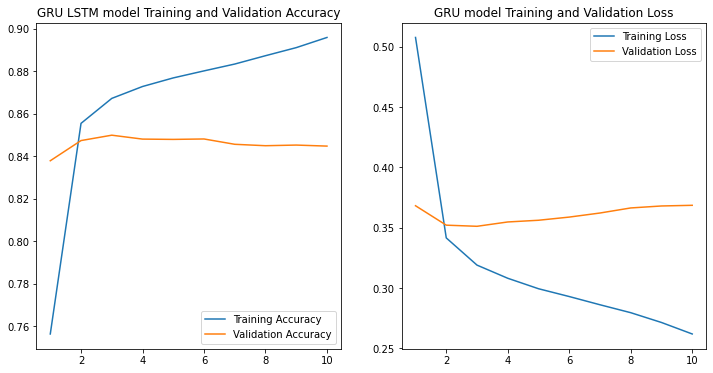

In [188]:
# history 객체에서 정확도와 손실 값 가져오기
acc = history_gru.history['accuracy']
val_acc = history_gru.history['val_accuracy']
loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# 정확도 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('GRU LSTM model Training and Validation Accuracy')

# 손실 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('GRU model Training and Validation Loss')

plt.show()

1. 훈련 정확도 (Training Accuracy) : 에포크(epoch)가 진행됨에 따라 지속적으로 상승하여 높은 값에 도달함. 모델이 훈련 데이터에 대해 점점 더 잘 맞추고 있다는 것을 나타냄.
2. 검증 정확도 (Validation Accuracy) : 초기 몇 에포크 동안 증가한 후 거의 일정한 수준을 유지하고 있음. 모델이 검증 데이터에 대해 초기에는 성능이 개선되었지만 이후에는 성능이 더 이상 개선되지 않고 있음.
3. 훈련 손실 (Training Loss) : 에포크가 진행됨에 따라 지속적으로 감소하고 있음. 모델이 훈련 데이터에 대해 점점 더 잘 맞추고 있다는 것을 나타냄.
4. 검증 손실 (Validation Loss) : 초기 몇 에포크 동안 감소한 후 다시 증가하고 일정한 수준을 유지하고 있음. 모델이 훈련 데이터에 과적합(overfitting)되고 있음.

### **하이퍼파라미터 튜닝하기**

In [145]:
!pip install keras_tuner

     |████████████████████████████████| 129 kB 4.9 MB/s            


In [146]:
from keras_tuner import RandomSearch

def build_model(hp):
    model = tf.keras.Sequential()
    # Embedding 레이어: 단어 벡터를 위한 임베딩 레이어
    model.add(tf.keras.layers.Embedding(vocab_size, hp.Int('embedding_dim', 
                                                            min_value=16, 
                                                            max_value=128, 
                                                            step=16), input_shape=(None,)))
    for i in range(hp.Int('num_layers', 1, 3)):
        # LSTM 레이어: 하이퍼파라미터 튜닝을 위해 여러 LSTM 레이어를 추가
        model.add(tf.keras.layers.LSTM(hp.Int('units_' + str(i), 
                                              min_value=16, 
                                              max_value=128, 
                                              step=16), 
                                              return_sequences=True))
    # GlobalMaxPooling1D 레이어: 1D 데이터의 최대 값을 추출
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    # Dense 레이어: 완전 연결 레이어
    model.add(tf.keras.layers.Dense(hp.Int('dense_units', min_value=16, 
                                                          max_value=128, 
                                                          step=16), 
                                                          activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# RandomSearch: 랜덤 서치를 통해 하이퍼파라미터를 튜닝
tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=5,   # max_trials=5: 5번의 다른 하이퍼파라미터 조합을 시도
                     executions_per_trial=3,  # executions_per_trial=3: 각 조합을 3번 실행하여 평균을 계산
                     directory='my_dir',
                     project_name='text_classification')

# tuner.search: 주어진 훈련 데이터와 검증 데이터를 사용하여 최적의 하이퍼파라미터 조합을 찾음
tuner.search(partial_x_train, partial_y_train, epochs=10, validation_data=(x_val, y_val))
best_model = tuner.get_best_models(num_models=1)[0]

results_best_model = best_model.evaluate(X_test_padded, y_test, verbose=2)
print(results_best_model)

Trial 5 Complete [00h 13m 09s]
val_accuracy: 0.8602904081344604

Best val_accuracy So Far: 0.8620272080103556
Total elapsed time: 01h 03m 15s
1537/1537 - 6s - loss: 0.3252 - accuracy: 0.8580
[0.3252263367176056, 0.8579652905464172]


[결과 해석]
* **val_accuracy**: 검증 데이터에서의 최고 정확도는 약 0.8620.
* **results_best_model**: 최적의 모델을 테스트 데이터셋에서 평가한 결과, 테스트 정확도는 약 0.8580.

모델이 검증 데이터와 테스트 데이터에서 상당히 일관된 성능을 보여주고 있음.

## **3. 자체학습한 임베딩과 사전학습 임베딩을 비교 분석하기**

### **필요한 라이브러리와 모델 불러오기**

In [164]:
import os
import numpy as np
from gensim.models import KeyedVectors
import tensorflow as tf

# Word2Vec 모델 로드
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = KeyedVectors.load(word2vec_file_path)

# 사전 학습된 Google News Word2Vec 모델 로드
google_news_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
google_news_vectors = KeyedVectors.load_word2vec_format(google_news_path, binary=True, limit=1000000)

# 자체 학습된 임베딩 레이어의 가중치 불러오기
embedding_layer = best_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 80)


### **자체 학습된 임베딩 파일로 저장하기**

In [167]:
import os
from gensim.models import Word2Vec, KeyedVectors

# 필요한 변수들
vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 80  # 워드 벡터의 차원수

# 모델 파일 경로
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'

# 모델 불러오기 (모델 로드 방식은 실제 파일 경로에 맞게 조정 필요)
word_vectors = KeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 단어 인덱스와 단어를 매핑하는 사전 (예시로 제공, 실제 데이터에 맞게 수정 필요)
index_to_word = {i: word for i, word in enumerate(word_vectors.index_to_key)}

# 파일에 기록
output_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_vectors.txt'
with open(output_file_path, 'w') as f:
    for i in range(4, min(vocab_size, len(word_vectors.index_to_key))):
        word = index_to_word[i]
        vector = word_vectors[word]
        f.write('{} {}\n'.format(word, ' '.join(map(str, vector))))

Word vectors saved successfully.


### **Gensim을 사용하여 자체 학습된 임베딩 모델 불러오기**

In [171]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 모델 파일 경로
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'

# 사전 학습된 word2vec 모델 불러오기
word_vectors = Word2Vec.load(word2vec_file_path)

# 단어 '끝'의 벡터 얻기
vector = word_vectors.wv['끝']

vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

### **비교 분석**

In [181]:
from gensim.models import Word2Vec, KeyedVectors
import os

# 유사 단어 찾기 함수 정의
def print_similar_words(word, model, topn=10):
    try:
        similar_words = model.most_similar(word, topn=topn)
        for word, similarity in similar_words:
            print(f'{word}: {similarity:.4f}')
    except KeyError:
        print(f"'{word}' not in vocabulary")

# 사전 학습된 Word2Vec 모델 로드
word2vec_pretrained_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2Vec.load(word2vec_pretrained_file_path)

# 단어 '끝'의 벡터 얻기
vector = word_vectors.wv['끝']

# 자체 학습된 임베딩 레이어의 가중치 불러오기
embedding_layer = best_model.layers[0]
weights = embedding_layer.get_weights()[0]

# 단어 인덱스와 단어를 매핑하는 사전
index_to_word = {i: word for i, word in enumerate(word_vectors.wv.index_to_key)}

# 새로운 KeyedVectors 객체를 생성하여 가중치 설정
custom_word_vectors = KeyedVectors(vector_size=weights.shape[1])
custom_word_vectors.add_vectors(list(index_to_word.values())[:weights.shape[0]], weights)

### **실험 결과**

In [182]:
print("자체 학습된 임베딩에서의 유사단어:")
print_similar_words("사랑", custom_word_vectors)

print("\n사전 학습된 임베딩에서의 유사단어:")
print_similar_words("사랑", word_vectors.wv)

자체 학습된 임베딩에서의 유사단어:
다가: 0.5680
였: 0.5438
좌우: 0.5127
한다: 0.4785
방향: 0.4586
목적: 0.4522
전: 0.4489
군대: 0.4411
다음: 0.4376
전동차: 0.4323

사전 학습된 임베딩에서의 유사단어:
이별: 0.7626
행복: 0.7550
슬픔: 0.7382
유혹: 0.7238
그리움: 0.7167
추억: 0.7144
꿈: 0.7089
애정: 0.7067
포옹: 0.7035
마음: 0.6973


In [183]:
print("자체 학습된 임베딩에서의 유사단어:")
print_similar_words("끝", custom_word_vectors)

print("\n사전 학습된 임베딩에서의 유사단어:")
print_similar_words("끝", word_vectors.wv)

자체 학습된 임베딩에서의 유사단어:
입지: 0.8820
붙이: 0.8777
요절: 0.8675
밴: 0.8643
스럽: 0.8626
지냈으며: 0.8578
서해: 0.8576
박자: 0.8576
쌍대: 0.8570
미쓰: 0.8566

사전 학습된 임베딩에서의 유사단어:
마지막: 0.6325
결판: 0.5526
발목: 0.5465
산산조각: 0.5419
막바지: 0.5413
싫증: 0.5257
양쪽: 0.5253
무릎: 0.5247
후: 0.5052
이어진: 0.5039


In [185]:
print("자체 학습된 임베딩에서의 유사단어:")
print_similar_words("축구", custom_word_vectors)

print("\n사전 학습된 임베딩에서의 유사단어:")
print_similar_words("축구", word_vectors.wv)

자체 학습된 임베딩에서의 유사단어:
솔: 0.7711
2016: 0.7287
내야수: 0.7168
사회: 0.6790
류: 0.6726
차트: 0.6691
자주: 0.6674
성분: 0.6659
수행: 0.6633
로운: 0.6582

사전 학습된 임베딩에서의 유사단어:
아이스하키: 0.8008
농구: 0.7926
배구: 0.7872
야구: 0.7544
축구팀: 0.7378
핸드볼: 0.7337
풋살: 0.7298
필드하키: 0.6769
킥복싱: 0.6682
테니스: 0.6669


자체 임베딩한 모델은 생각보다 이 단어가 유사한가? 라는 생각이 들었다. 이에 더해 전처리를 덜해서 필요 없는 부분이 있기도 했다. 반면 사전 학습된 임베딩한 모델에서는 누가 봐도 비슷한 단어네라고 생각할 만한 단어가 많았다. 결과적으로 보면 실패한 실험이라고 볼 수 있다.

## **4. 회고**
***

[배운 점 & 느낀 점] 이번 학습을 통해 다양한 모델에 대해 실습하고, 어떻게 하면 더 좋은 모델을 학습할 수 있는지, 혹은 이미 잘 학습 되어있는 데이터셋과 비교했을 때 얼마나 학습이 잘 될 수 있는지 알아보게 된 시간이어서 좋았던 것 같다. 루브릭 중 하나인 정확도 85%를 넘는 미션이 있었는데, 결국 RandomSearch를 통해 이를 달성할 수 있었어서 좋았다.

[어려운 점 & 아쉬웠던 점] 앞서 언급했다시피 자체 임베딩한 모델의 성능이 좋지 않아서 아쉬웠다. 또한 정확도 85%를 넘기기가 어려워서 애를 먹었는데, RandomSearch 방법으로 달성하기까지 시간이 오래걸렸다. 물론 Transformer 모델도 있지만, 이는 나중에 많이 써먹을 것 같아서 아껴두기로 했다. 그래도 위안을 얻었던 것은 조별 학습으로 이야기할 때, 정희님께서 한 단어가 다른 단어와 같이 많이 나오는 단어라고 얘기해주셔서 감사했다.